# Nonlinear Buckling of a Reinforced Box Beam

***

In this notebook we analyze the nonlinear buckling behavior of a box beam reinforced with several ribs along its span.

* [Geometry and material properties](#geometry)
* [Setup of the numerical model](#numerical-model)
* [Mesh convergence study](#mesh-convergence)
* [Nonlinear analysis: load-displacement diagram](#load-displacement-diagram)
* [Nonlinear analysis: sensitivity of nonlinear analysis parameters](#nonlinear-analysis-parameters)
* [Nonlinear analysis: nonlinear buckling method verification](#nonlinear-buckling-method-verification)
* [Conclusions](#conclusions)

## Geometry and material properties <a name="geometry"></a>

***

We consider a box beam with the following geometry.

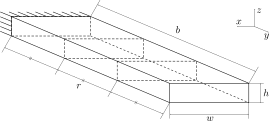

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces
SVG(filename=os.path.join('resources', '08_ReinforcedBoxBeamGeometry.svg'))

Let's define the planform and the cross-section of our box beam.

In [2]:
AR = 9   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- span: {b/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

Box beam dimensions:
- width: 1.0 m
- span: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


We define number and location of the ribs.

In [3]:
import numpy as np

# Prescribed spacing
ribs_spacing = w/2
# Number of ribs based on prescribed spacing
no_ribs = int(np.ceil(b/ribs_spacing)) + 1
print(f'Number of ribs: {no_ribs:.0f}')
# Find prescribed ribs location
ribs_y_locations = np.linspace(0, b, no_ribs)

Number of ribs: 10


We define the material properties.

In [4]:
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

## Setup of the numerical model <a name="numerical-model"></a>

***

We use the package `pyvista` to generate a mesh of our box beam in terms of a list of nodes coordinates and a list of the indices of the nodes composing each element.

We define the following functions:
- `mesh_box` to generate a mesh of a box section without ribs;
- `mesh_rib` to generate a mesh of a rib;
- `mesh_box_beam` to combine the box and rib meshes and generate the final mesh of our box beam.

Let's select a shell element with a prescribed edge lenght equal to the height of the box beam and let's generate and plot the corresponding mesh.

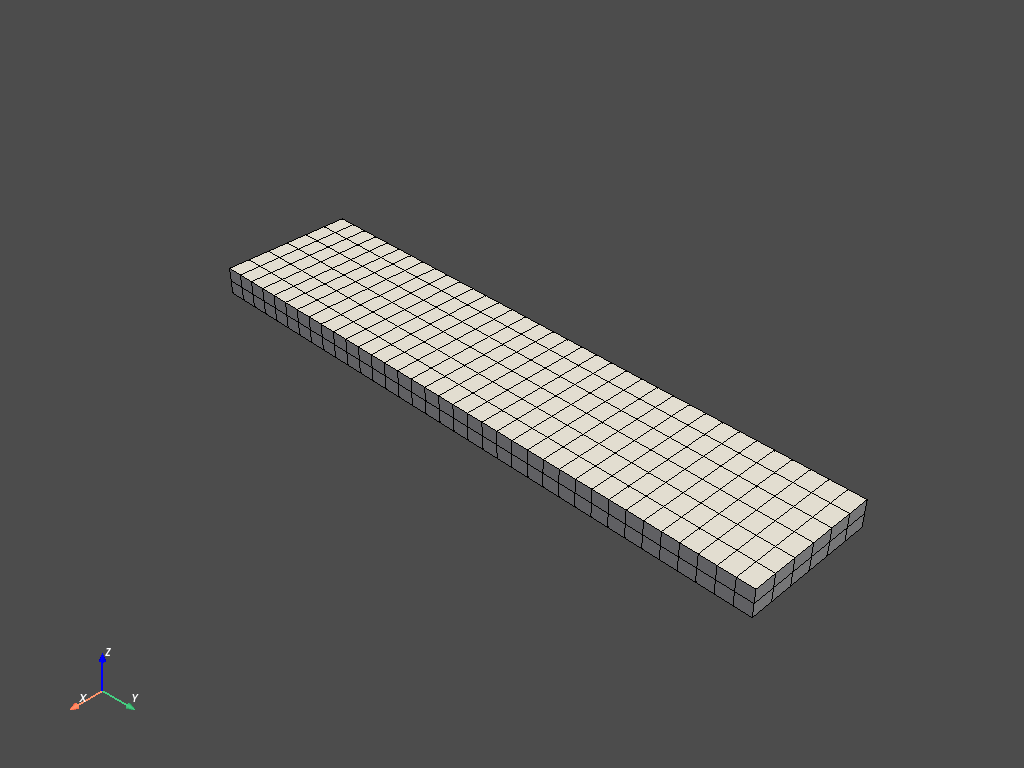

In [5]:
from resources import box_beam_utils

example_shell_element_edge = h  # [mm]
example_box_beam_mesh = box_beam_utils.mesh_box_beam_pyvista(ribs_y_locations, w, h, edge_length=example_shell_element_edge)
example_box_beam_mesh.plot(show_edges=True, jupyter_backend='static')

Now we define a function to create a base bdf input with material properties, nodes, CQUAD4 elements and boundary conditions.

In [6]:
from pyNastran.bdf.bdf import BDF

def create_base_bdf_input(young_modulus, poisson_ratio, density, shell_thickness, mesh):
    # Create BDF object
    bdf_input = BDF(debug=False)
    # Add material card
    material_id = 1
    bdf_input.add_mat1(mid=material_id, E=young_modulus, G='', nu=poisson_ratio, rho=density)
    # Add element property card
    property_id = 1
    bdf_input.add_pshell(pid=property_id, mid1=material_id, t=shell_thickness, mid2=material_id, mid3=material_id)
    # Define nodes based on the points of the PolyData object
    nodes_coordinates = mesh.points
    nodes_ids = np.arange(1, np.size(nodes_coordinates, 0)+1)
    for count, node_xyz in enumerate(nodes_coordinates):
        bdf_input.add_grid(nid=nodes_ids[count], xyz=node_xyz)
    # Define shell elements based on the faces of the PolyData object
    faces_connectivity_array = mesh.faces.reshape(-1, 5)[:, 1:]
    elements_ids = np.arange(1, np.size(faces_connectivity_array, 0)+1)
    for count, nodes_indices in enumerate(faces_connectivity_array):
        bdf_input.add_cquad4(eid=elements_ids[count], pid=property_id, nids=[nodes_ids[nodes_indices[0]], nodes_ids[nodes_indices[1]], nodes_ids[nodes_indices[2]], nodes_ids[nodes_indices[3]]])
    # Define boundary conditions constraining the nodes at the root
    root_nodes_ids = nodes_ids[np.abs(nodes_coordinates[:,1])<shell_thickness/100]
    constraint_set_id = 1
    bdf_input.add_spc1(constraint_set_id, '123456', root_nodes_ids)
    bdf_input.create_subcases(0)
    bdf_input.case_control_deck.subcases[0].add_integer_type('SPC', constraint_set_id)
    # Set defaults for output files
    bdf_input.add_param('POST', [1])  # add PARAM card to store results in a op2 file
    bdf_input.case_control_deck.subcases[0].add('ECHO', 'NONE', [], 'STRING-type')  # request no Bulk Data to be printed
    bdf_input.case_control_deck.subcases[0].add_result_type('DISPLACEMENT', 'ALL', ['PLOT'])  # store displacement data of all nodes in the op2 file
    bdf_input.case_control_deck.subcases[0].add_result_type('SPCFORCES', 'ALL', ['PLOT'])  # store single point constraint forces data in the op2 file
    bdf_input.case_control_deck.subcases[0].add_result_type('OLOAD', 'ALL', ['PLOT'])  # store form and type of applied load vector
    # Return BDF object
    return bdf_input

We are going to consider a concentrated load applied at the tip, as shown below, so we define a function to apply such load.

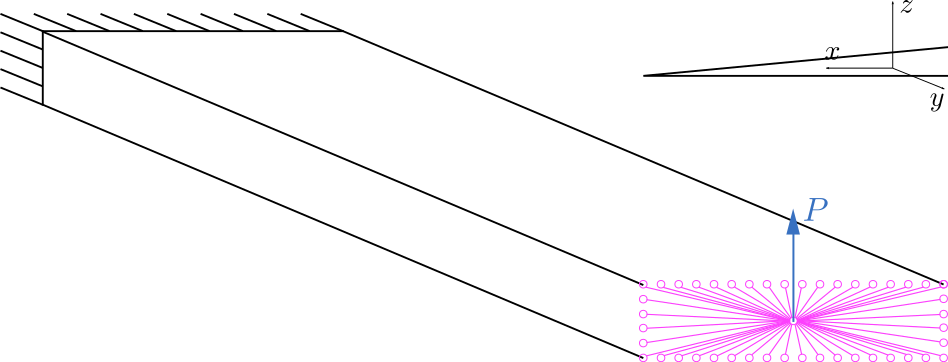

In [7]:
SVG(filename=os.path.join('resources', '08_ReinforcedBoxBeamConcentratedLoad.svg'))

In [8]:
from resources import pynastran_utils

def apply_tip_concentrated_load(bdf_input, mesh, force_id):
    # Store array of nodes ids
    nodes_coordinates_array = mesh.points
    # Find outer nodes of tip rib
    nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
    tolerance = t/25
    outer_tip_nodes_ids = nodes_ids[(np.abs(nodes_coordinates_array[:, 1] - b) < tolerance) & ((nodes_coordinates_array[:, 0] < tolerance) | (np.abs(nodes_coordinates_array[:, 0] - w) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] - h/2) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] + h/2) < tolerance))]
    # Add master node of tip section
    tip_section_master_node_id = np.amax(nodes_ids) + 1
    bdf_input.add_grid(tip_section_master_node_id, [w/2, b, 0.])
    # Add RBE3 to connect master node with outer nodes of tip rib
    rbe3_eid = len(bdf_input.elements) + 1
    bdf_input.add_rbe3(eid=rbe3_eid, refgrid=tip_section_master_node_id, refc='123456', weights=[1.]*len(outer_tip_nodes_ids), comps=['123456']*len(outer_tip_nodes_ids), Gijs=outer_tip_nodes_ids)
    # Add concentrated force
    force_direction = [0., 0., 1.]
    pynastran_utils.add_unitary_force(bdf_object=bdf_input, nodes_ids=[tip_section_master_node_id], set_id=force_id, direction_vector=force_direction)

## Mesh convergence study <a name="mesh-convergence"></a>

***

We run a mesh convergence study checking the value of the linear buckling load predicted by SOL 105.

Prescribed edge length of shell elements for mesh convergence study [mm]:
[200. 151. 114.  86.  65.  49.  37.  28.  21.  16.]

Results for model with:
- 200.0 mm shell element linear size
- 696 elements
- 3726 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 3341 N
Buckling mode:


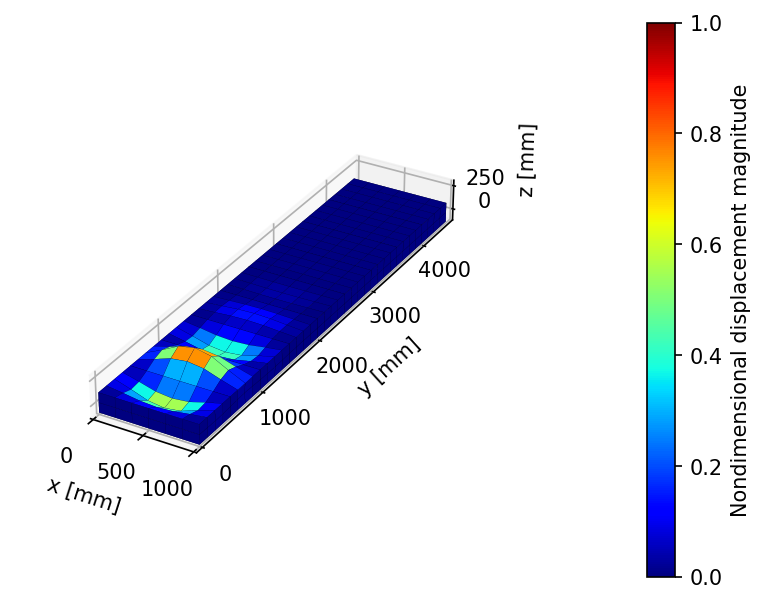


Results for model with:
- 151.1 mm shell element linear size
- 880 elements
- 4698 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 3329 N
Buckling mode:


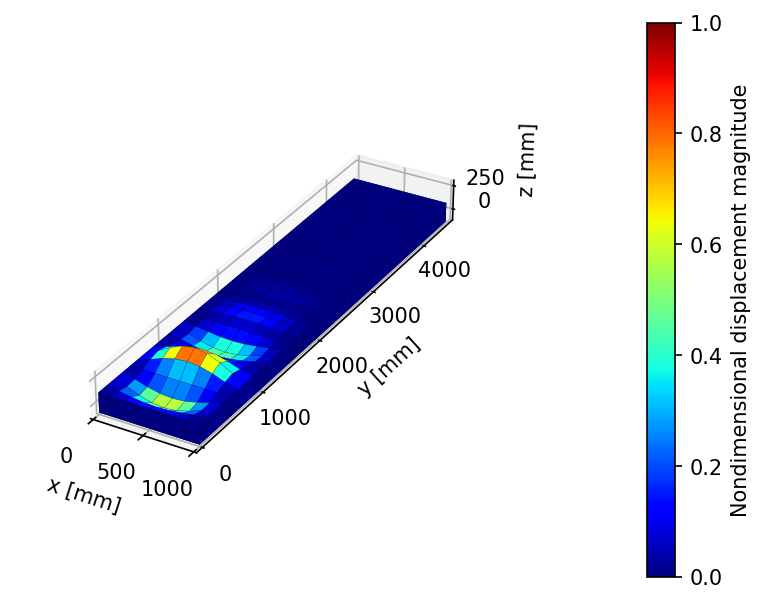


Results for model with:
- 114.1 mm shell element linear size
- 1496 elements
- 8262 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 3172 N
Buckling mode:


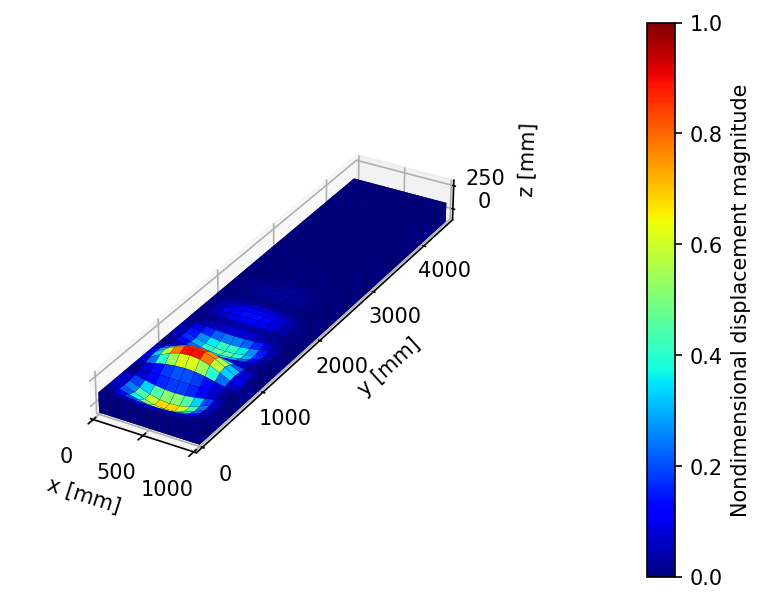


Results for model with:
- 86.2 mm shell element linear size
- 2208 elements
- 12150 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 3166 N
Buckling mode:


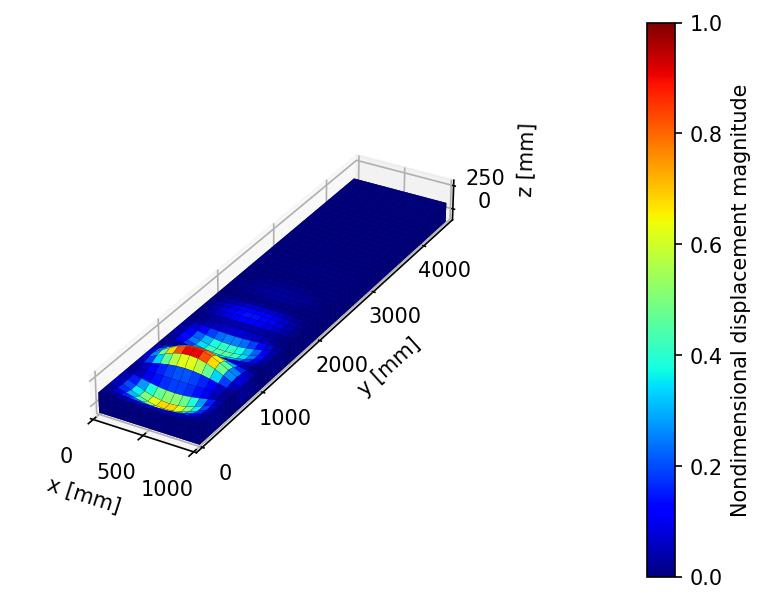


Results for model with:
- 65.1 mm shell element linear size
- 3520 elements
- 19710 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 3120 N
Buckling mode:


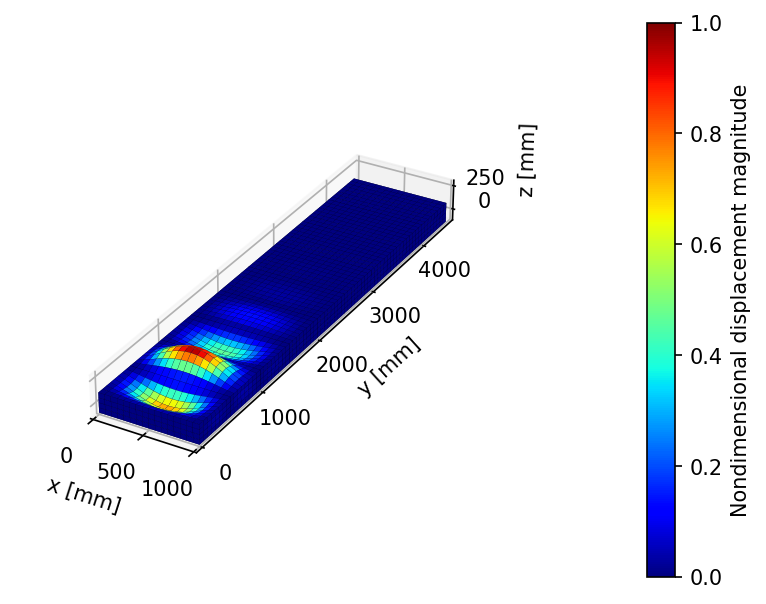

subcase=0 already exists...skipping



Results for model with:
- 49.2 mm shell element linear size
- 7368 elements
- 41958 degrees of freedom
Nastran job linear_buckling_7368_elements.bdf completed
Wall time: 4.0 s


Buckling load: 3094 N
Buckling mode:


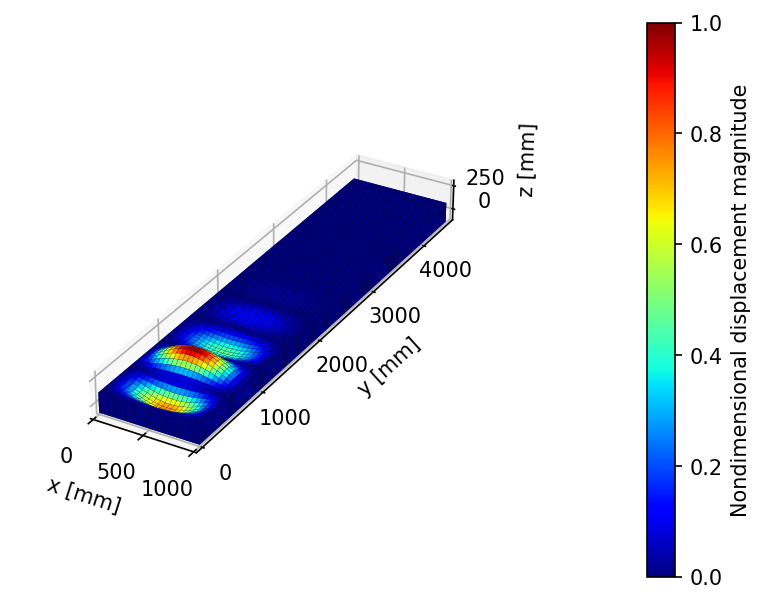

subcase=0 already exists...skipping



Results for model with:
- 37.1 mm shell element linear size
- 10248 elements
- 58698 degrees of freedom
Nastran job linear_buckling_10248_elements.bdf completed
Wall time: 5.0 s


Buckling load: 3089 N
Buckling mode:


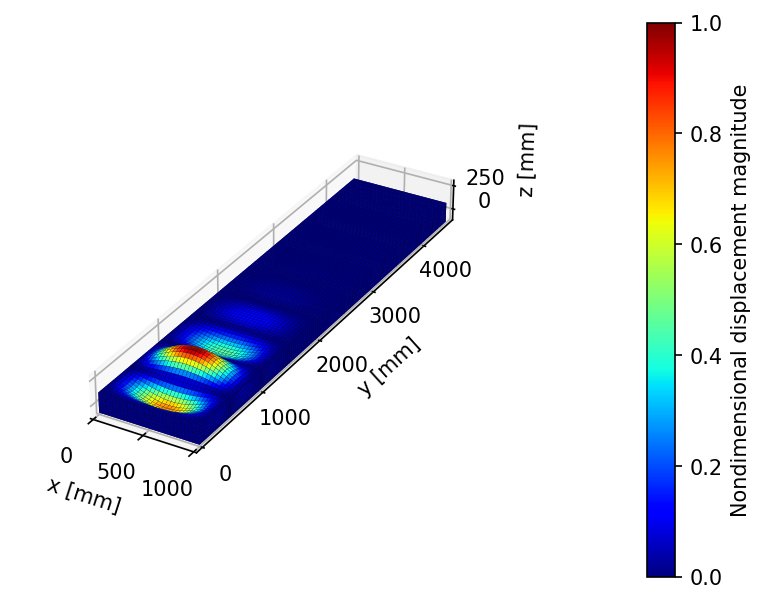

subcase=0 already exists...skipping



Results for model with:
- 28.0 mm shell element linear size
- 17136 elements
- 98766 degrees of freedom
Nastran job linear_buckling_17136_elements.bdf completed
Wall time: 11.0 s


Buckling load: 3086 N
Buckling mode:


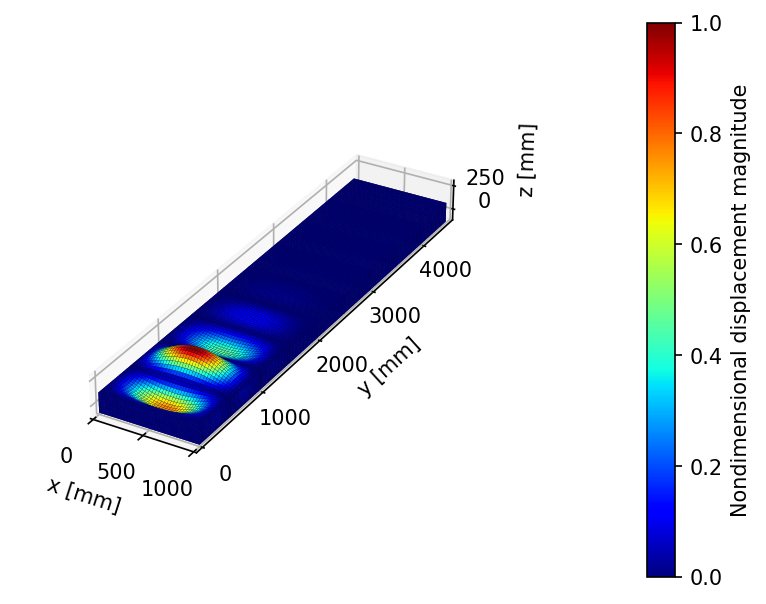

subcase=0 already exists...skipping



Results for model with:
- 21.2 mm shell element linear size
- 29856 elements
- 173178 degrees of freedom
Nastran job linear_buckling_29856_elements.bdf completed
Wall time: 19.0 s


Buckling load: 3083 N
Buckling mode:


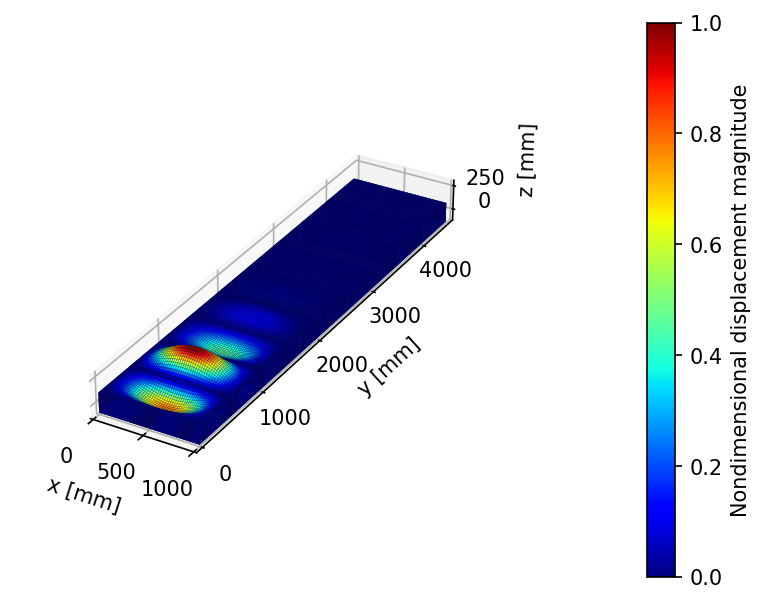

subcase=0 already exists...skipping



Results for model with:
- 16.0 mm shell element linear size
- 53888 elements
- 313794 degrees of freedom
Nastran job linear_buckling_53888_elements.bdf completed
Wall time: 31.0 s


Buckling load: 3082 N
Buckling mode:


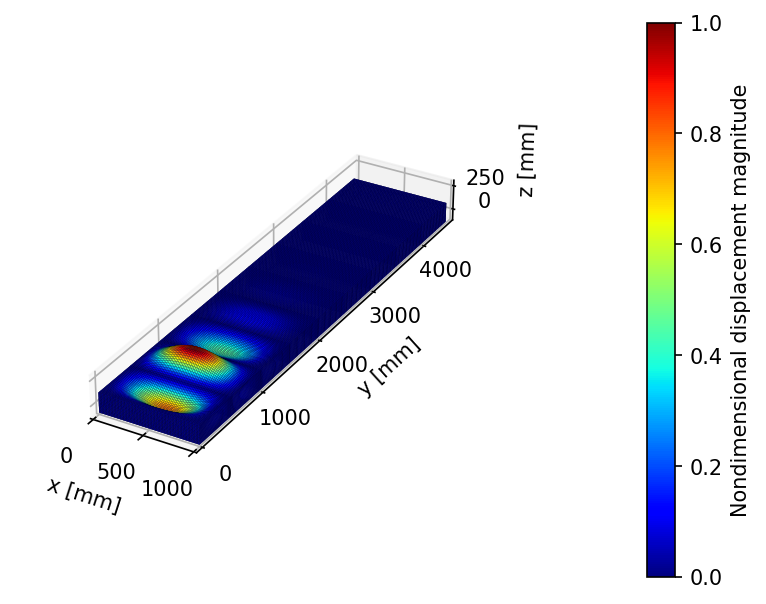

In [9]:
import matplotlib.pyplot as plt  # plotting library
from resources import box_beam_utils

# Set default dpi of figures
plt.rcParams['figure.dpi'] = 150
# Define name of analysis directory and of input file
analysis_directory_name = '08_Nonlinear_Buckling_Box_Beam_With_Ribs'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
# Define set id of FORCE card
force_set_id = 11
# Define edge length of the shell elements to be used for the mesh convergence study
shell_element_edges = np.geomspace(h, t*4, 10) # [mm]
print('Prescribed edge length of shell elements for mesh convergence study [mm]:')
np.set_printoptions(precision=0)
print(shell_element_edges)
# Initialize arrays with number of degrees of freedom and linear buckling load
dofs = np.empty(np.shape(shell_element_edges))
linear_buckling_loads = np.ones(np.shape(shell_element_edges))
# Iterate through the shell element lengths
for i, edge in enumerate(shell_element_edges):
    # Generate bdf input
    box_beam_mesh = box_beam_utils.mesh_box_beam_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h, edge_length=edge)
    box_beam_bdf_input = create_base_bdf_input(E, nu, rho, t, box_beam_mesh)
    # Store number of degrees of freedom
    constrained_nodes_ids = next(iter(box_beam_bdf_input.spcs.values()))[0].node_ids
    dofs[i] = (len(box_beam_bdf_input.nodes) - len(constrained_nodes_ids))*6
    # Print info about current analysis
    no_elements = len(box_beam_bdf_input.elements)
    print(f'\n\033[1mResults for model with:\n- {edge:.1f} mm shell element linear size\n- {no_elements:.0f} elements\n- {dofs[i]:.0f} degrees of freedom\033[0m')
    # Apply uniform load
    apply_tip_concentrated_load(box_beam_bdf_input, box_beam_mesh, force_set_id)
    # Calculate linear buckling load and plot shape
    input_name = 'linear_buckling_' + str(no_elements) + '_elements'
    linear_buckling_loads[i] = box_beam_utils.calculate_linear_buckling_load(box_beam_bdf_input, force_set_id, analysis_directory_path, input_name, run_flag=False, plot_shape=True)

We plot the results to examine the convergence of the buckling load as the number of degrees of freedom increases.

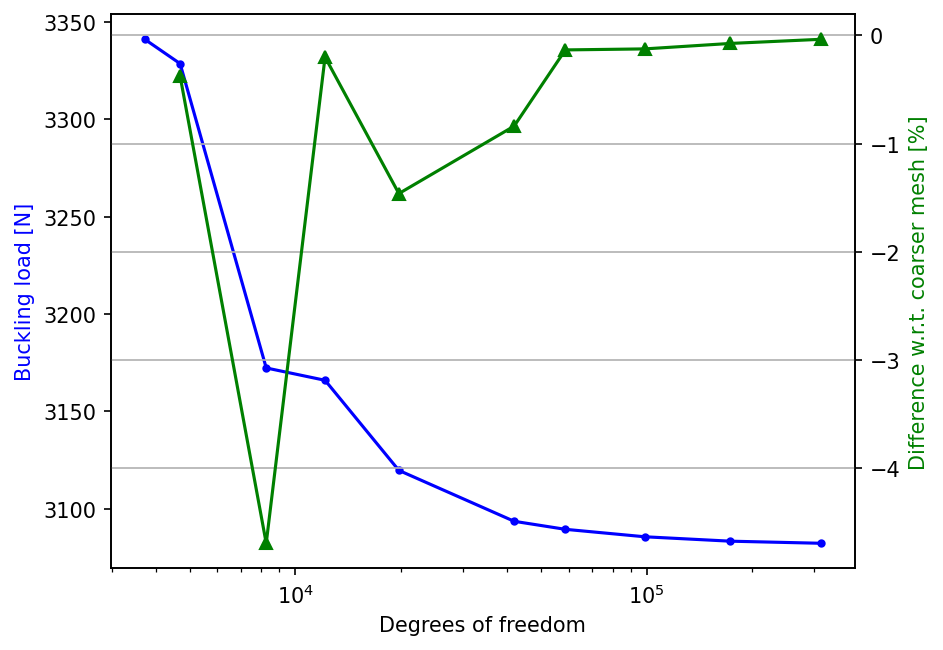

In [10]:
# Plot degrees of freedom vs buckling loads with a log scale along the x-axis
plt.semilogx(dofs, linear_buckling_loads, 'b.-')
# Add second y-axis on the right of the plot
ax1 = plt.gca()
ax2 = ax1.twinx()
# Calculate the percentage difference of each buckling load with respect to the one obtained with the coareser mesh
percentage_diff = (linear_buckling_loads[1:]/linear_buckling_loads[0:-1]-1)*100
# Plot degrees of freedom vs the percentage difference
ax2.plot(dofs[1:], percentage_diff, 'g^-')
# Set the axes label and the grid
ax1.set_xlabel('Degrees of freedom')
ax1.set_ylabel('Buckling load [N]', color='b')
ax2.set_ylabel('Difference w.r.t. coarser mesh [%]', color='g')
plt.grid()
plt.show()

We define the mesh to be converged when the percentage difference with respect to previous mesh is permanently below 1%.

In [11]:
# Find shell element size, degrees of freedom and buckling load corresponding to converged mesh
converged_mesh_index = np.where(np.abs(percentage_diff)<1)[0][2]+1
converged_shell_element_edge = shell_element_edges[converged_mesh_index]
sol105_buckling_load = linear_buckling_loads[converged_mesh_index]
print(f'The mesh is converged for an approximate shell element size of {converged_shell_element_edge:.0f} mm, corresponidng to {dofs[converged_mesh_index]:.0f} degrees of freedom and to a linear buckling load of {sol105_buckling_load:.0f} N.')

The mesh is converged for an approximate shell element size of 49 mm, corresponidng to 41958 degrees of freedom and to a linear buckling load of 3094 N.


## Nonlinear analysis: load-displacement diagram <a name="load-displacement-diagram"></a>

***

Now we want to run a nonlinear analysis and have a look at the load-displacement diagram to check whether our box beam exhibits a nonlinear behavior. We are going to load the structure with twice the buckling load predicted by SOL 105 to push our box beam out of the linear regime.

Let's create a `BDF` object with nodes, elements, material properties, boundary conditions and concetrated tip load. Then we set up SOL 106 and the related nonlinear analysis parameters.

In [12]:
# Create BDF object with nodes, elements, material properties and boundary conditions
box_beam_mesh = box_beam_utils.mesh_box_beam_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h, edge_length=converged_shell_element_edge)
box_beam_bdf_input = create_base_bdf_input(E, nu, rho, t, box_beam_mesh)
# Apply concentrated load at tip equal to twice the buckling load predicted by SOL 105
apply_tip_concentrated_load(box_beam_bdf_input, box_beam_mesh, force_set_id)
load_set_id = force_set_id+1
scale_factor = sol105_buckling_load*2
box_beam_bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])
# Setup SOL 106 with nonlinear analysis parameters
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf_input)
# Create static load subcase
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf_input, subcase_id=1, load_set_id=load_set_id)

subcase=0 already exists...skipping


Now let's run our nonlinear analysis.

In [13]:
input_filename = 'nonlinear_analysis_reference'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf_input, filename=input_filename, run_flag=False)

Nastran job nonlinear_analysis_reference.bdf completed
Wall time: 14.0 s


We read the op2 file and plot results in terms of load-displacement diagram and of deformed shape at the end of the analysis. For the load-displacement diagram, the monitored displacement is the one along the $z$-axis at the node at the center of the tip section.

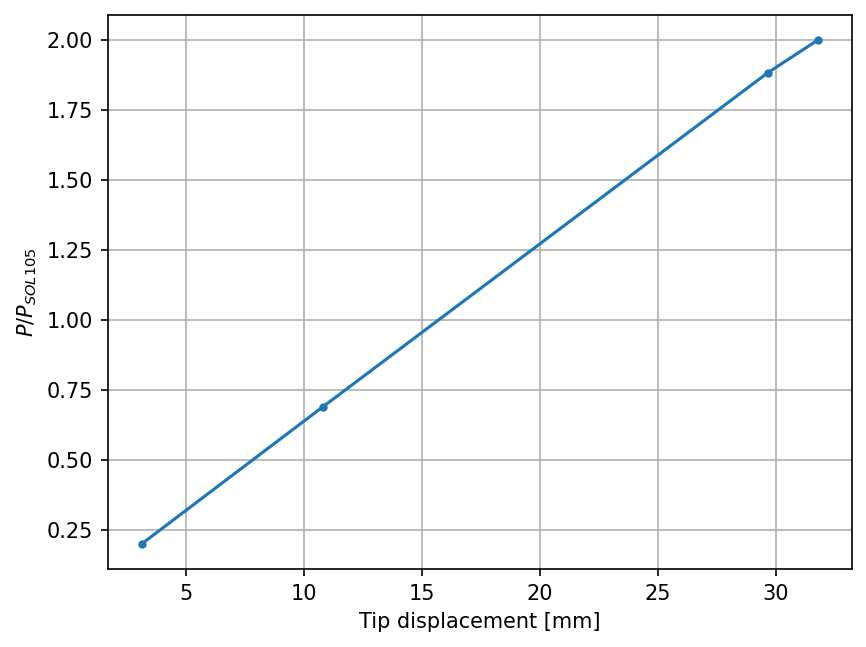

(<Figure size 960x720 with 2 Axes>,
 <Axes3DSubplot:xlabel='x [mm]', ylabel='y [mm]'>)

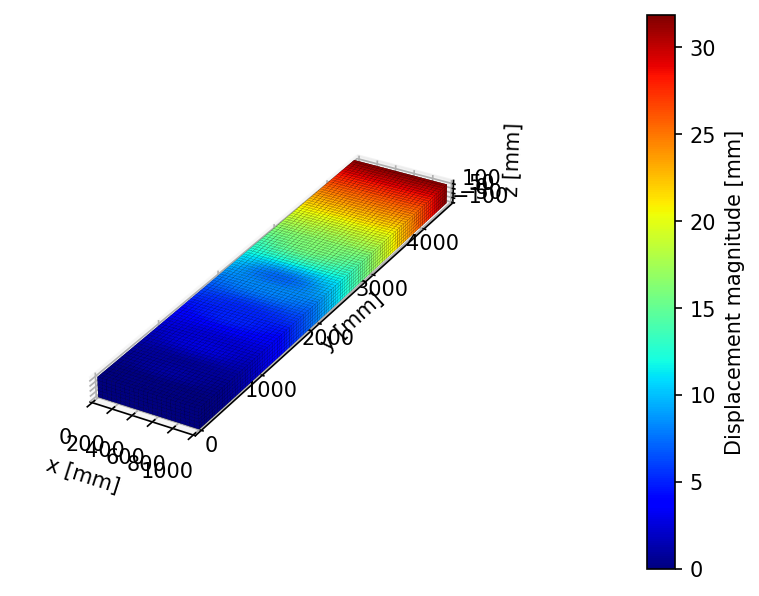

In [14]:
from pyNastran.op2.op2 import read_op2  # function to read op2 file

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False, load_geometry=True)
# Find load and displacement history
master_node_id = len(box_beam_bdf_input.nodes)
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
# Select translation along z as the load and displacement components to plot
load_component_index = 2
displacement_component_index = 2
# Plot load-displacement diagram
_, ax = plt.subplots()
ax.plot(displacements[1][:,displacement_component_index], loads[1][:, load_component_index]/sol105_buckling_load, '.-')
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.grid()
plt.show()
# Plot structural deformation
pynastran_utils.plot_static_deformation(op2_object=op2_output)

We can observe a change in the slope of the load-displacement curve between the last two points. However, this change in slope seems to happen well above the buckling load predicted by SOL 105. We also notice that the deformed shape of the structure is characterized by some blobs over the top skin, suggesting the presence of a post-buckled shape.

## Nonlinear analysis: sensitivity of nonlinear analysis parameters <a name="nonlinear-analysis-parameters"></a>

***

Now we want to assess the influence of SOL 106's nonlinear analysis parameters on the load-displacement diagram of our box beam.

Let's define a function to read load and displacement history and plot it on an existent figure.

In [15]:
def plot_load_displacement_curve(bdf_input, filename, axes, marker_style, line_label, run_flag=True):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=filename, run_flag=run_flag)
    # Read load and displacement history from op2 file
    op2_path = os.path.join(analysis_directory_path, filename + '.op2')
    op2 = read_op2(op2_path, debug=False)
    _, p, disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=master_node_id)
    # Plot load-displacement curve on input axes
    axes.plot(disp[1][:,displacement_component_index], p[1][:, load_component_index]/sol105_buckling_load, marker=marker_style, linestyle='-', label=line_label)

Before proceeding with our investigation, we find the id of the NLPARM card to modify its parameters and we define a list of marker characters that we will use to plot the various load-displacement curves.

In [16]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

# Get list of marker characters
markers = list(Line2D.markers.keys())[2:]
# Find id of NLPARM card
nlparm_id = next(iter(box_beam_bdf_input.nlparms))

We start by investigating the influence of the error functions.

Nastran job nonlinear_analysis_error_function_PW.bdf completed
Wall time: 14.0 s


Nastran job nonlinear_analysis_error_function_PUV.bdf completed
Wall time: 15.0 s


Nastran job nonlinear_analysis_error_function_PWU.bdf completed
Wall time: 14.0 s


Nastran job nonlinear_analysis_error_function_PWUV.bdf completed
Wall time: 14.0 s


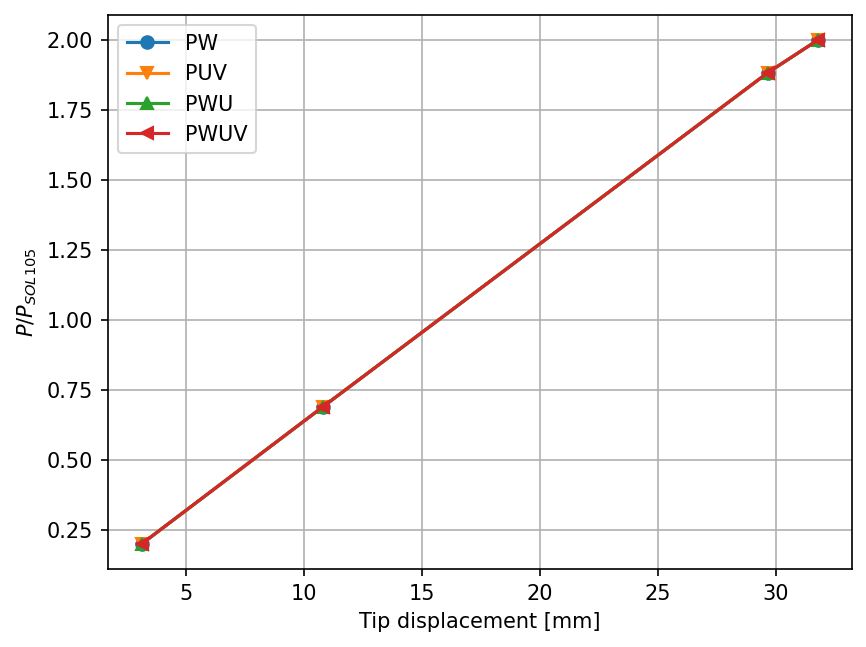

In [17]:
# Define error functions
error_functions = ['PW', 'PUV', 'PWU', 'PWUV']
# Create figure
_, ax = plt.subplots()
# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    box_beam_bdf_input.nlparms[nlparm_id].conv = fun
    input_filename = 'nonlinear_analysis_error_function_' + fun
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'{fun}', run_flag=False)
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.legend()
plt.grid()
plt.show()

The choice of the error function does not appear to influence the load-displacement curve. As a consequence we switch back to the default load and energy functions.

In [18]:
box_beam_bdf_input.nlparms[nlparm_id].conv = 'PW'

Now we investigate the influence of convergence tolerances.

Nastran job nonlinear_analysis_load_tolerance_0_100.bdf completed
Wall time: 13.0 s


Nastran job nonlinear_analysis_load_tolerance_0_010.bdf completed
Wall time: 15.0 s


Nastran job nonlinear_analysis_load_tolerance_0_001.bdf completed
Wall time: 34.0 s


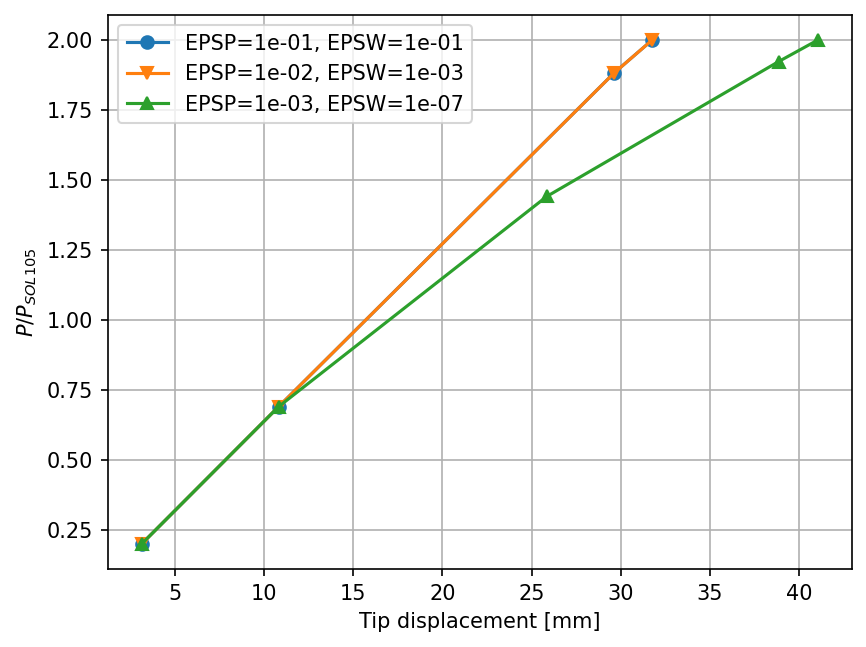

In [19]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]
# Create figure
_, ax = plt.subplots()
# Run analysis for each couple of convergence tolerances and plot load-displacement diagram
for count, epsp in enumerate(load_tolerances):
    epsw = work_tolerances[count]
    box_beam_bdf_input.nlparms[nlparm_id].eps_p = epsp
    box_beam_bdf_input.nlparms[nlparm_id].eps_w = epsw
    input_filename = f'nonlinear_analysis_load_tolerance_{epsp:.3f}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'EPSP={epsp:.0e}, EPSW={epsw:.0e}', run_flag=False)
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.legend()
plt.grid()
plt.show()

The use of tighter error tolerances appears to significatively influence the load-displacement curve. For this reason we keep the tighter tolerances for our further analyses.

Let's vary the initial load increment $\Delta\mu^1$.

Nastran job nonlinear_analysis_initial_load_increment_0_50.bdf completed
Wall time: 22.0 s


Nastran job nonlinear_analysis_initial_load_increment_0_10.bdf completed
Wall time: 32.0 s


Nastran job nonlinear_analysis_initial_load_increment_0_01.bdf completed
Wall time: 54.0 s


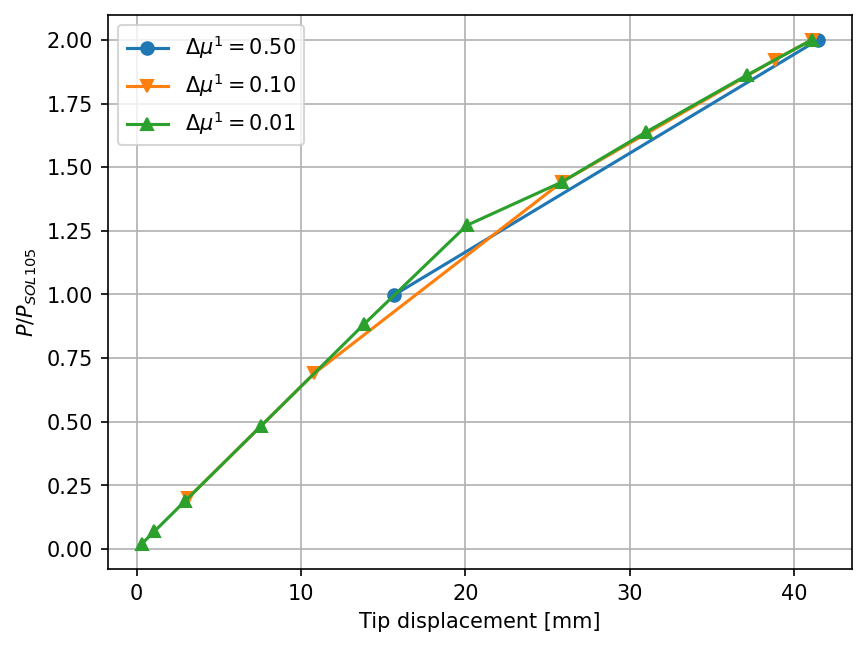

In [20]:
# Define initial load increments
initial_load_increments = [.5, .1, .01]
# Create figure
_, ax = plt.subplots()
# Run analysis for each initial load increment and plot load-displacement diagram
for count, delta_mu_1 in enumerate(initial_load_increments):
    box_beam_bdf_input.nlparms[nlparm_id].ninc = int(1/delta_mu_1)
    input_filename = f'nonlinear_analysis_initial_load_increment_{delta_mu_1:.2f}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'$\Delta\mu^1={delta_mu_1:.2f}$', run_flag=False)
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.legend()
plt.grid()
plt.show()

A small initial load increment gives a more defined load-displacement curve. For this reason we keep $\Delta\mu^1=0.01$ for the successive analyses.

Now we investigate the influence of the desired number of iterations.

Nastran job nonlinear_analysis_desiter_20.bdf completed
Wall time: 56.0 s


Nastran job nonlinear_analysis_desiter_12.bdf completed
Wall time: 57.0 s


Nastran job nonlinear_analysis_desiter_5.bdf completed
Wall time: 63.0 s


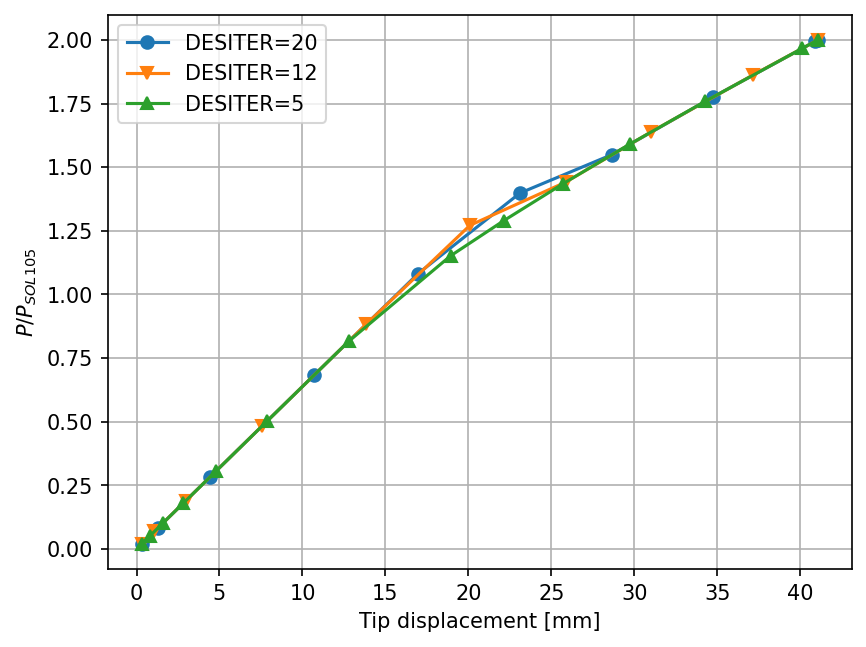

In [21]:
# Define desired numbers of iterations
no_iterations = [20, 12, 5]
# Create figure
_, ax = plt.subplots()
# Run analysis for each desired number of iterations and plot load-displacement diagram
for count, desiter in enumerate(no_iterations):
    box_beam_bdf_input.nlpcis[nlparm_id].desiter = desiter
    input_filename = 'nonlinear_analysis_desiter_' + str(desiter)
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'DESITER={desiter}', run_flag=False)
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.legend()
plt.grid()
plt.show()

A small number of desired iterations gives a more defined load-displacement curve. For this reason we keep $DESITER=5$ for further analyses.

Let's vary the minimum allowable arc-length adjustment ratio.

Nastran job nonlinear_analysis_minalr_0_90.bdf completed
Wall time: 57.0 s


Nastran job nonlinear_analysis_minalr_0_25.bdf completed
Wall time: 65.0 s


Nastran job nonlinear_analysis_minalr_0_01.bdf completed
Wall time: 69.0 s


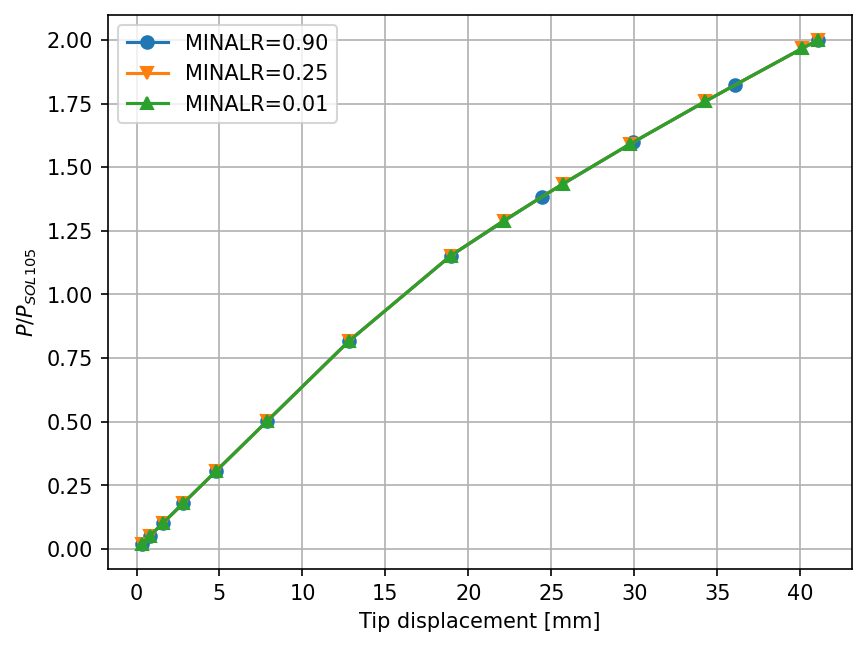

In [22]:
# Define minimum allowable arc-length adjustment ratios
min_arclength_adjustment_ratios = [.9, .25, .01]
# Create figure
_, ax = plt.subplots()
# Run analysis for each minimum allowable arc-length adjustment ratio and plot load-displacement diagram
for count, minalr in enumerate(min_arclength_adjustment_ratios):
    box_beam_bdf_input.nlpcis[nlparm_id].minalr = minalr
    input_filename = f'nonlinear_analysis_minalr_{minalr:.2f}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'MINALR={minalr:.2f}', run_flag=False)
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.legend()
plt.grid()
plt.show()

The minimum allowable arc-length adjustment ratio does not appear to have any influence on the load-displacement curve. For this reason we switch back to the default value $MINALR=0.25$.

In [23]:
box_beam_bdf_input.nlpcis[nlparm_id].minalr = .25

Finally, we investigate the influence of the last parameter: the maximum allowable arc-length adjustment ratio.

Nastran job nonlinear_analysis_maxalr_10_0.bdf completed
Wall time: 67.0 s


Nastran job nonlinear_analysis_maxalr_4_0.bdf completed
Wall time: 66.0 s


Nastran job nonlinear_analysis_maxalr_1_1.bdf completed
Wall time: 83.0 s


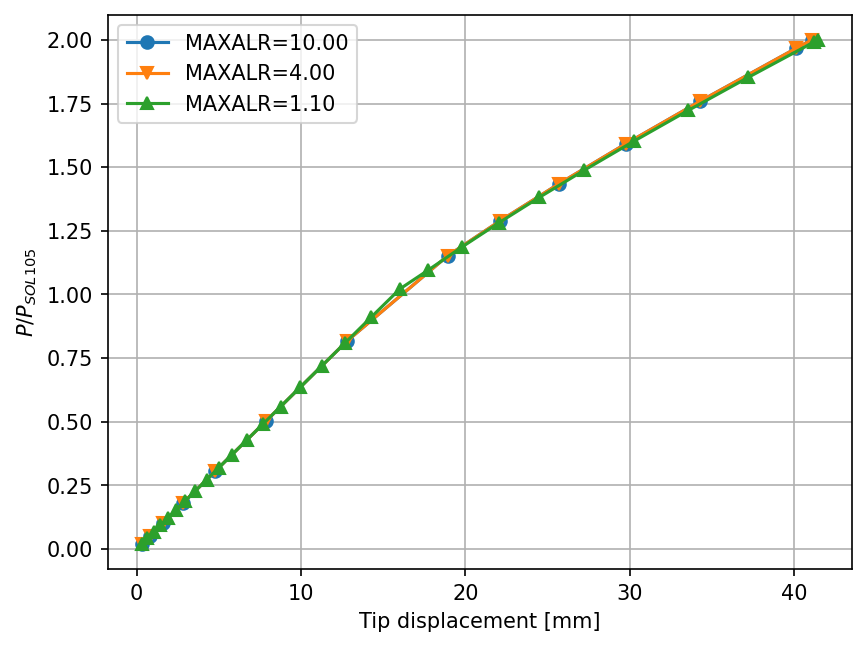

In [24]:
# Define maximum allowable arc-length adjustment ratios
max_arclength_adjustment_ratios = [10., 4., 1.1]
# Create figure
_, ax = plt.subplots()
# Run analysis for each maximum allowable arc-length adjustment ratio and plot load-displacement diagram
for count, maxalr in enumerate(max_arclength_adjustment_ratios):
    box_beam_bdf_input.nlpcis[nlparm_id].maxalr = maxalr
    input_filename = f'nonlinear_analysis_maxalr_{maxalr:.1f}'.replace('.','_')
    plot_load_displacement_curve(box_beam_bdf_input, input_filename, ax, markers[count], f'MAXALR={maxalr:.2f}', run_flag=False)
# Set axes label, legend and grid
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.legend()
plt.grid()
plt.show()

A small maximum allowable arc-length adjustment ratio gives a more defined load-displacement curve. For this reason we keep MAXALR=1.1$ for our final analysis.

## Nonlinear analysis: nonlinear buckling method verification <a name="nonlinear-buckling-method-verification"></a>

***

Now we want to apply SOL 106's nonlinear buckling method and verify its applicability monitoring the lowest eigenvalue of the tangent stiffness matrix.

Let's define several subcases with increasing applied load, up to twice the buckling load predicted by SOL 105.

In [25]:
# Define and print applied load magnitudes
applied_load_magnitudes = np.linspace(0, sol105_buckling_load*2, 11)[1:]
np.set_printoptions(precision=0, suppress=True)
print(f'Applied loads [N]: {applied_load_magnitudes}')
# Modify first subcase
box_beam_bdf_input.load_combinations[load_set_id][0].scale_factors[0] = applied_load_magnitudes[0]
# Create new subcases
for i, scale_factor in enumerate(applied_load_magnitudes[1:], start=1):
    load_set_id = load_set_id+i
    box_beam_bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])
    pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf_input, subcase_id=1+i, load_set_id=load_set_id)

Applied loads [N]: [ 619. 1237. 1856. 2475. 3094. 3712. 4331. 4950. 5568. 6187.]



We add the parameters needed for the nonlinear buckling method to our bdf input.

In [26]:
box_beam_bdf_input.add_param('BUCKLE', [2])
eigrl_set_id = load_set_id+1
box_beam_bdf_input.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)
box_beam_bdf_input.case_control_deck.subcases[0].add_integer_type('METHOD', eigrl_set_id)

We add the DMAP sequence to calculate the lowest eigenvalue of the tangent stiffness matrix at every iteration.

In [27]:
box_beam_bdf_input.executive_control_lines[1:1] = ['include \'' + os.path.join(os.pardir, os.pardir, 'resources', 'kllrh_lowest_eigv.dmap') + '\'']  # include DMAP sequence

Increase maximum number of controlled increments.

In [28]:
box_beam_bdf_input.nlpcis[nlparm_id].mxinc = 200

Let's run our nonlinear analysis.

In [29]:
input_filename = 'nonlinear_buckling_verification'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf_input, filename=input_filename, run_flag=True)

Nastran job nonlinear_buckling_verification.bdf completed
Wall time: 907.0 s


Let's plot the results in terms of applied load versus critical buckling factor ALPHA and buckling load predicted by SOL 106.

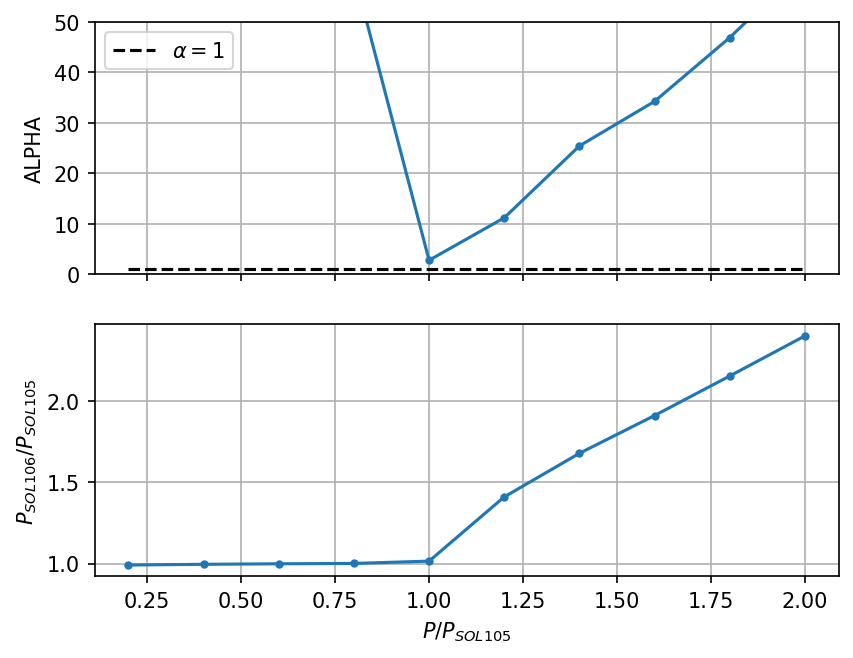

In [30]:
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False, load_geometry=True)
# Find load and displacement history
load_steps, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=master_node_id)
# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_filename + '.f06'), op2_object=op2_output)
# Collect load and displacement history
load_history = np.concatenate([loads[subcase_id][:, load_component_index] for subcase_id in displacements])
displacement_history = np.concatenate([displacements[subcase_id][:,displacement_component_index] for subcase_id in displacements])
# Create figure with subplots
fig, axs = plt.subplots(nrows=2, ncols=1, sharex='all')
# Plot critical buckling factors vs applied loads
axs[0].plot(applied_load_magnitudes/sol105_buckling_load, critical_buckling_factors, '.-')
reference, = axs[0].plot(applied_load_magnitudes/sol105_buckling_load, [1]*len(applied_load_magnitudes), '--k', label='$\\alpha=1$')
# Plot nonlinear buckling loads vs applied loads
axs[1].plot(applied_load_magnitudes/sol105_buckling_load, nonlinear_buckling_loads/sol105_buckling_load, '.-')
# Set plot appearance
axs[0].set_ylabel('ALPHA')
axs[0].set_ylim([0, 50])
axs[0].legend(handles=[reference])
axs[0].grid(visible=True)
axs[1].set_xlabel('$P/P_{SOL 105}$')
axs[1].set_ylabel('$P_{SOL 106}/P_{SOL 105}$')
axs[1].grid(visible=True)
# Show plot
plt.show()

The critical buckling factor ALPHA is always larger than 1, suggesting that the critical point detected by SOL 106's nonlinear buckling method is always far from the last converged solution of each subcase. The buckling load predicted by SOL 106 is close to the one predicted by SOL 105 up to an applied load of $P/P_{SOL 105}=1$ and then it increases in a linear fashion. This is similar to what we observed for the unreinforced box beam and for the imperfect Euler's column

Let's also plot the load-displacement diagram and the structural deformation at the end of our analysis.

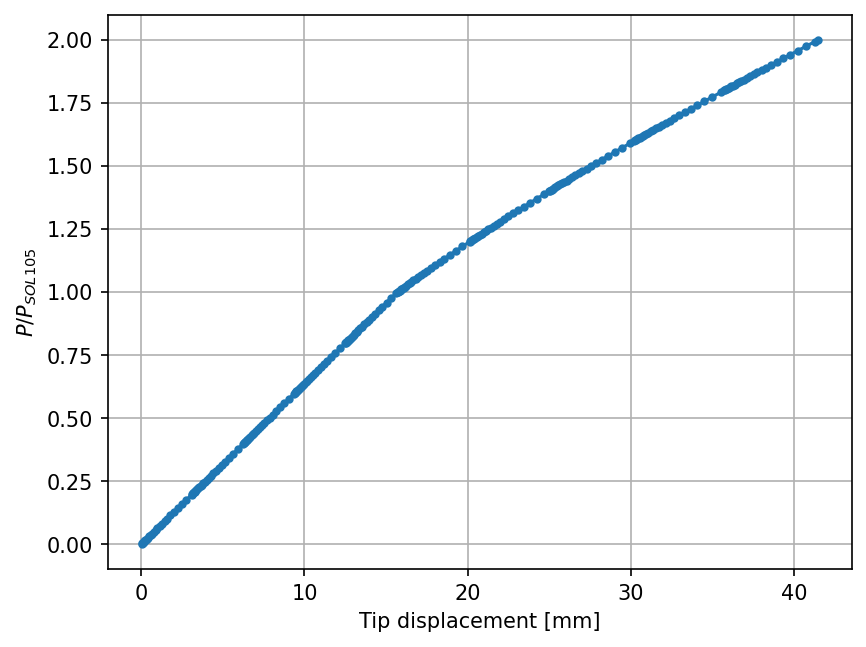

(<Figure size 960x720 with 2 Axes>,
 <Axes3DSubplot:xlabel='x [mm]', ylabel='y [mm]'>)

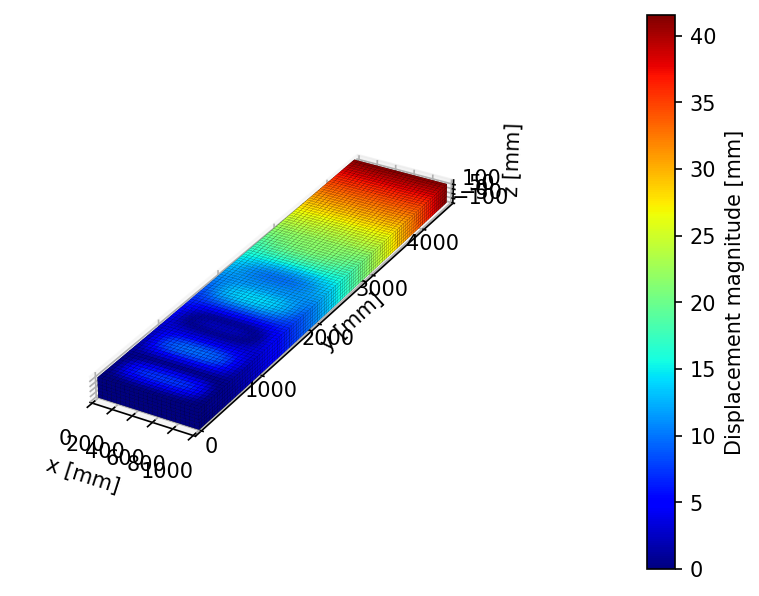

In [31]:
# Plot load-displacement diagram
_, ax = plt.subplots()
ax.plot(displacement_history, load_history/sol105_buckling_load, '.-')
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.grid()
plt.show()
# Plot structural deformation
valid_subcase_ids = [subcase_id for subcase_id in op2_output.load_vectors if hasattr(op2_output.load_vectors[subcase_id], 'lftsfqs')]
pynastran_utils.plot_static_deformation(op2_object=op2_output, subcase_id=valid_subcase_ids[-1])

A change in stiffness of the load-displacement curve can be clearly detected around $P/P_{SOL 105}=1$. The deformed shape of the box beam at the end of our analysis suggests that the top skin assumes a buckled-like shape and this affects the global stiffness of the structure.

Finally, we plot the lowest eigenvalue of the tangent stiffness matrix.

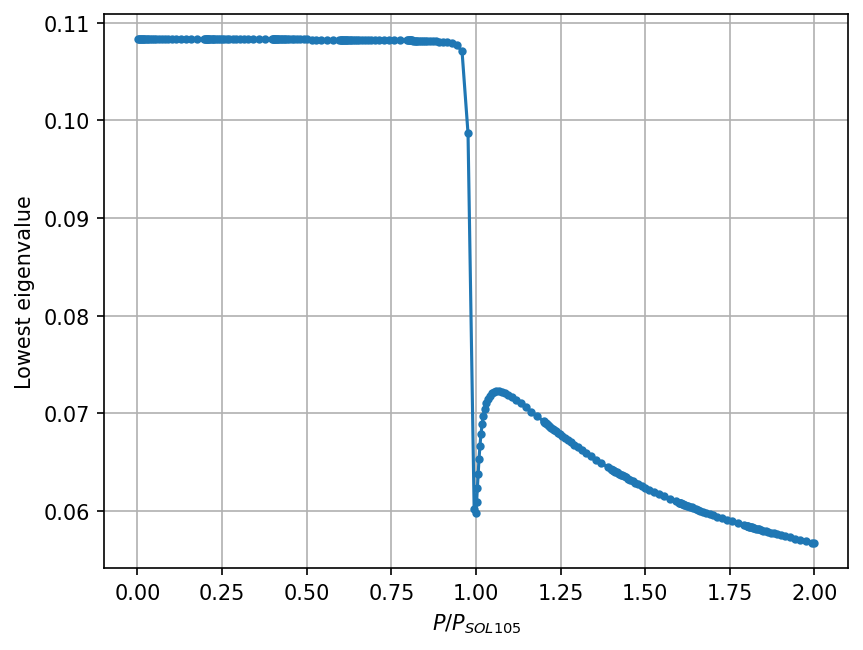

In [32]:
# Read the lowest eigenvalue of KLLRH matrices from f06 file
f06_filepath = os.path.join(analysis_directory_path, input_filename + '.f06')  # path to .f06 file
lowest_eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)
# Create new figure and plot load history vs lowest eigenvalues
_, ax = plt.subplots()
ax.plot(load_history/sol105_buckling_load, lowest_eigenvalues, '.-')
plt.xlabel('$P/P_{SOL 105}$')
plt.ylabel('Lowest eigenvalue')
plt.grid()
plt.show()

The lowest eigenvalue is constant up to a load slightly smaller than $P/P_{SOL 105}=1$, where it undergoes an abrupt decrease. This must correspond with the top skin assuming a buckled-like shape and consequently inducing a nonlinearity in the global behavior of the structure. However, the lowest eigenvalue never becomes negative, meaning that the structure does not encounter a critical point and it always stays in a stable equilibrium configuration.

## Conclusions <a name="conclusions"></a>

***

The analyzed box beam reinforced with ribs exhibits a linear pre-buckling behavior. Approximately at the buckling load predicted by SOL 105 it shows a nonlinear softening beahvior in the load-displacement diagram. The lowest eigenvalue of the tangent stiffness matrix is always positve, meaning that there is no critical point in the equilibrium branch determined by the load applied in our analysis.

***

The cell below executes the style for this notebook. We use a slightly modified version of the custom style found on the GitHub of [barbagroup](https://github.com/barbagroup), [@LorenaABarba](https://twitter.com/LorenaABarba).

In [33]:
from IPython.core.display import HTML
def css_styling():
    styles = open(os.path.join(os.pardir, 'styles', 'custom.css'), 'r').read()
    return HTML(styles)
css_styling()